### Defining high-risk community-platform pairs

In [24]:
import pandas as pd

nlp = pd.read_parquet(
    r"D:\Varun Kumar\Proejekt\Data\processed\nlp_sample_full.parquet"
)

risk = (
    nlp
    .groupby(["community","platform"])[["toxicity","identity_attack","threat"]]
    .mean()
    .reset_index()
)

risk["risk_score"] = (
    0.5 * risk["toxicity"] +
    0.3 * risk["identity_attack"] +
    0.2 * risk["threat"]
)

risk.sort_values("risk_score", ascending=False).head(10)


,community,platform,toxicity,identity_attack,threat,risk_score
1,CringeAnarchy,voat,0.269963,0.054131,0.008730,0.152967
10,milliondollarextreme,reddit,0.263011,0.047818,0.009392,0.147729
6,fatpeoplehate,reddit,0.281269,0.018233,0.006445,0.147393
7,fatpeoplehate,voat,0.272251,0.020422,0.005777,0.143408
0,CringeAnarchy,reddit,0.253844,0.035331,0.006745,0.138871
11,milliondollarextreme,voat,0.227832,0.060986,0.010317,0.134275
5,MensRights,voat,0.225288,0.035992,0.007891,0.125020
4,MensRights,reddit,0.189291,0.015928,0.004317,0.100288
2,KotakuInAction,reddit,0.176537,0.014616,0.003761,0.093405
3,KotakuInAction,voat,0.136951,0.014668,0.003623,0.073600


In [ ]:
# Compare Reddit vs Voat risk

pivot_risk = risk.pivot_table(
    index="community",
    columns="platform",
    values="risk_score"
).reset_index()

pivot_risk["voat_minus_reddit"] = pivot_risk["voat"] - pivot_risk["reddit"]
pivot_risk.sort_values("voat_minus_reddit", ascending=False).head(10)


platform,community,reddit,voat,voat_minus_reddit
2,MensRights,0.100288,0.125020,0.024732
4,greatawakening,0.043468,0.058497,0.015028
0,CringeAnarchy,0.138871,0.152967,0.014096
3,fatpeoplehate,0.147393,0.143408,-0.003986
5,milliondollarextreme,0.147729,0.134275,-0.013454
1,KotakuInAction,0.093405,0.073600,-0.019805


In [26]:
import duckdb

db = duckdb.connect()

MADOC_PATH = r"D:\Varun Kumar\Proejekt\Data\processed\madoc_all.parquet"

engagement = db.execute(f"""
SELECT
    community,
    platform,
    COUNT(*) AS posts
FROM read_parquet('{MADOC_PATH}')
WHERE language = 'English'
GROUP BY community, platform
""").fetchdf()

risk = pd.merge(risk, engagement, on=["community","platform"])


In [27]:
posts_sample = (
    nlp.groupby(["community","platform"])
       .size()
       .reset_index(name="posts_sample")
)

risk = pd.merge(risk, posts_sample, on=["community","platform"])

risk["danger"] = risk["risk_score"] * risk["posts_sample"]


In [28]:
nlp["error"] = abs(nlp["toxicity"] - nlp["sentiment_bert"])

error_by_comm = (
    nlp.groupby(["community","platform"])["error"]
    .mean()
    .reset_index()
)


### Danger vs Model Error by Community

In [29]:
risk = pd.merge(risk, error_by_comm, on=["community","platform"])
risk.sort_values("error", ascending=False).head()

,community,platform,toxicity,identity_attack,threat,risk_score,posts,posts_sample,danger,error
6,fatpeoplehate,reddit,0.281269,0.018233,0.006445,0.147393,1409008,7226,1065.064257,1.174152
7,fatpeoplehate,voat,0.272251,0.020422,0.005777,0.143408,353514,49522,7101.826326,1.165434
1,CringeAnarchy,voat,0.269963,0.054131,0.008730,0.152967,3032,417,63.787151,1.149595
0,CringeAnarchy,reddit,0.253844,0.035331,0.006745,0.138871,6445396,31999,4443.717298,1.145591
10,milliondollarextreme,reddit,0.263011,0.047818,0.009392,0.147729,1286148,6402,945.762104,1.138407


In [30]:
plot_df = risk.groupby("community").agg({
    "danger": "sum",
    "error": "mean"
}).reset_index()


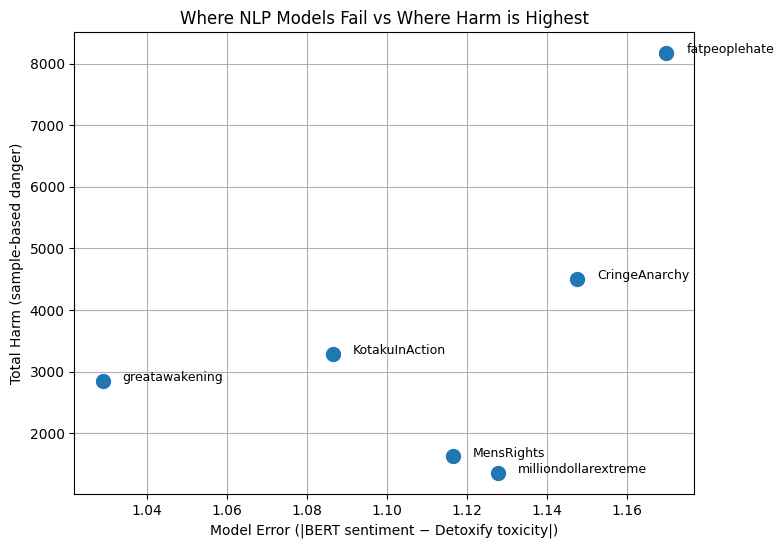

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.scatter(plot_df["error"], plot_df["danger"], s=100)

for _, row in plot_df.iterrows():
    plt.text(row["error"]+0.005, row["danger"], row["community"], fontsize=9)

plt.xlabel("Model Error (|BERT sentiment − Detoxify toxicity|)")
plt.ylabel("Total Harm (sample-based danger)")
plt.title("Where NLP Models Fail vs Where Harm is Highest")
plt.grid(True)
plt.show()
